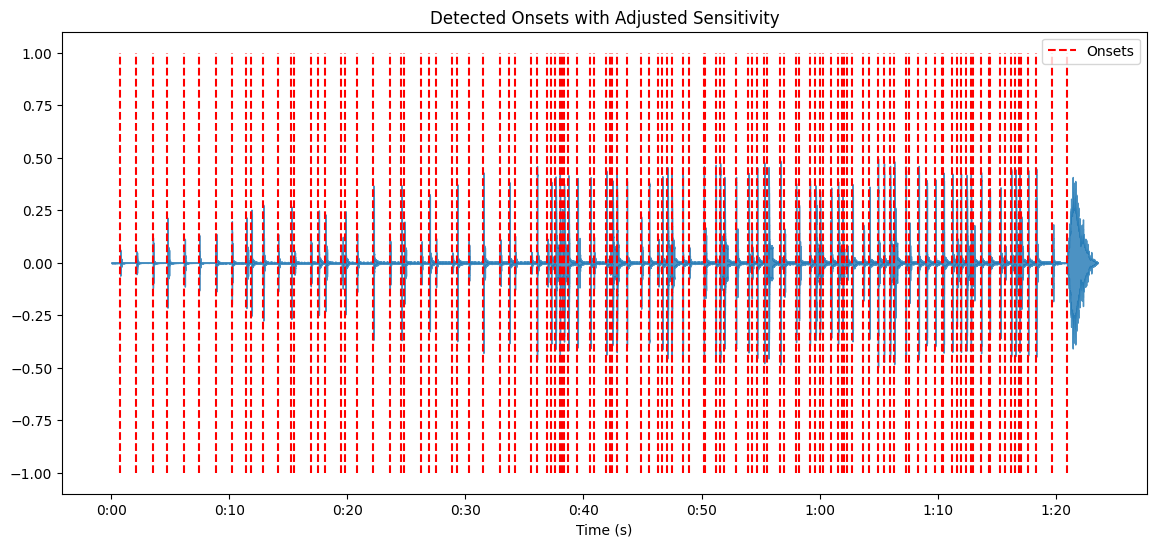

Onset times (in seconds): [ 0.75464853  2.08979592  3.51201814  4.73106576  6.141678    7.41297052
  8.82358277 10.19356009 11.43582766 11.86539683 12.82902494 14.11773243
 15.24390023 15.48770975 16.88671202 17.53687075 18.09414966 19.48734694
 19.82984127 20.79927438 22.15764172 23.57986395 24.578322   24.81052154
 26.20952381 26.93514739 27.49823129 28.87981859 29.30358277 30.26721088
 31.50367347 32.90267574 33.72117914 34.18557823 35.55555556 36.0431746
 36.94875283 37.23900227 37.5814966  37.98204082 38.20263039 38.34195011
 38.7076644  39.46811791 40.58267574 40.88453515 41.92362812 42.26612245
 42.42285714 42.80598639 43.67092971 44.87836735 45.54013605 46.27736961
 46.67791383 47.07845805 47.46739229 48.39038549 48.92444444 50.18993197
 50.33505669 51.18839002 51.55410431 51.92562358 52.89505669 53.97478458
 54.23600907 54.70621315 55.29251701 55.58276644 56.65668934 57.00498866
 57.98603175 58.25886621 59.17605442 59.65206349 60.02938776 60.27319728
 60.93496599 61.56770975 6

In [1]:
# Import necessary libraries
import librosa
import librosa.display
import matplotlib.pyplot as plt
import requests

# Download the file to a local path
# audio_url = 'https://github.com/egorpol/beat_it/raw/refs/heads/main/examples/parm2_mono.aif'
local_audio_path = 'examples/parm2_mono.aif'

# # Download the file
# response = requests.get(audio_url)
# with open(local_audio_path, 'wb') as f:
#     f.write(response.content)

# Define the hop length globally
hop_length = 128

# Load the audio file
y, sr = librosa.load(local_audio_path)

# Onset detection with custom sensitivity
onset_frames = librosa.onset.onset_detect(y=y, sr=sr,
                                          delta=0.12,       # Lower value for more sensitivity (default is 0.07)
                                          backtrack=True,   # Enable backtracking to improve onset timing
                                          pre_max=10,       # Increase to be less sensitive to nearby peaks
                                          post_max=10,      # Increase for less sensitivity to nearby peaks
                                          hop_length=hop_length)  # Use global hop length

# Convert onset frames to times
onset_times = librosa.frames_to_time(onset_frames, sr=sr, hop_length=hop_length)  # Use global hop length

# Plot the waveform and onset times
plt.figure(figsize=(14, 6))
librosa.display.waveshow(y, sr=sr, alpha=0.8)
plt.vlines(onset_times, ymin=-1, ymax=1, color='r', linestyle='--', label='Onsets')
plt.title('Detected Onsets with Adjusted Sensitivity')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

# Print the onset times
print('Onset times (in seconds):', onset_times)


In [2]:
import numpy as np

iois = np.diff(onset_times)

print(iois)


[1.33514739 1.42222222 1.21904762 1.41061224 1.27129252 1.41061224
 1.36997732 1.24226757 0.42956916 0.96362812 1.28870748 1.1261678
 0.24380952 1.39900227 0.65015873 0.55727891 1.39319728 0.34249433
 0.96943311 1.35836735 1.42222222 0.99845805 0.23219955 1.39900227
 0.72562358 0.5630839  1.3815873  0.42376417 0.96362812 1.23646259
 1.39900227 0.8185034  0.46439909 1.36997732 0.48761905 0.90557823
 0.29024943 0.34249433 0.40054422 0.22058957 0.13931973 0.36571429
 0.76045351 1.11455782 0.30185941 1.03909297 0.34249433 0.15673469
 0.38312925 0.86494331 1.20743764 0.66176871 0.73723356 0.40054422
 0.40054422 0.38893424 0.9229932  0.53405896 1.26548753 0.14512472
 0.85333333 0.36571429 0.37151927 0.96943311 1.07972789 0.26122449
 0.47020408 0.58630385 0.29024943 1.0739229  0.34829932 0.98104308
 0.27283447 0.91718821 0.47600907 0.37732426 0.24380952 0.66176871
 0.63274376 0.37151927 0.12770975 0.2554195  0.45278912 0.92879819
 0.52244898 0.71401361 0.510839   0.50503401 0.37151927 0.95782

Can we extract the drops?

In [4]:
import numpy as np

# Desired interval and tolerance
interval = 1.35    # Desired interval in seconds
tolerance = 0.2   # Tolerance in seconds

# Build a directed acyclic graph (DAG) where nodes are onset times
edges = {t: [] for t in onset_times}

# Construct edges between onset times that are approximately 'interval' apart
for i in range(len(onset_times)):
    for j in range(i + 1, len(onset_times)):
        delta_t = onset_times[j] - onset_times[i]
        if abs(delta_t - interval) <= tolerance:
            edges[onset_times[i]].append(onset_times[j])

# Function to find the longest path starting from a given node
def find_longest_path(node, edges, memo):
    if node in memo:
        return memo[node]
    max_length = 1
    max_path = [node]
    for neighbor in edges[node]:
        path = find_longest_path(neighbor, edges, memo)
        if 1 + len(path) > max_length:
            max_length = 1 + len(path)
            max_path = [node] + path
    memo[node] = max_path
    return max_path

# Find all longest sequences in the DAG
memo = {}
longest_length = 0
longest_paths = []

for node in onset_times:
    path = find_longest_path(node, edges, memo)
    if len(path) > longest_length:
        longest_length = len(path)
        longest_paths = [path]
    elif len(path) == longest_length:
        longest_paths.append(path)

# Output all sequences that have the longest length
for idx, path in enumerate(longest_paths):
    print(f"Sequence {idx + 1}:")
    print(np.array(path))


Sequence 1:
[ 0.75464853  2.08979592  3.51201814  4.73106576  6.141678    7.41297052
  8.82358277 10.19356009 11.43582766 12.82902494 14.11773243 15.48770975
 16.88671202 18.09414966 19.48734694 20.79927438 22.15764172 23.57986395
 24.81052154 26.20952381 27.49823129 28.87981859 30.26721088 31.50367347
 32.90267574 34.18557823 35.55555556 36.94875283 38.20263039 39.46811791
 40.88453515 42.26612245 43.67092971 44.87836735 46.27736961 47.46739229
 48.92444444 50.18993197 51.55410431 52.89505669 54.23600907 55.58276644
 57.00498866 58.25886621 59.65206349 60.93496599 62.32235828 63.70394558
 64.94040816 66.32780045 67.61070295 69.00970522 70.39709751 71.6277551
 72.81777778 74.32126984 75.70285714 76.93351474 78.32090703 79.71410431
 80.96798186]


In [5]:
# Automatically detect the number of sequences
num_sequences = len(longest_paths)

# Loop through all sequences and print them dynamically
for idx in range(num_sequences):
    sequence = longest_paths[idx]
    print(f"Sequence {idx + 1}:")
    print(np.array(sequence))

    # You can store each sequence in a variable dynamically if needed
    # e.g., if you want to store the first sequence:
    if idx == 0:
        seq1 = sequence
    elif idx == 1:
        seq2 = sequence
    elif idx == 2:
        seq3 = sequence


Sequence 1:
[ 0.75464853  2.08979592  3.51201814  4.73106576  6.141678    7.41297052
  8.82358277 10.19356009 11.43582766 12.82902494 14.11773243 15.48770975
 16.88671202 18.09414966 19.48734694 20.79927438 22.15764172 23.57986395
 24.81052154 26.20952381 27.49823129 28.87981859 30.26721088 31.50367347
 32.90267574 34.18557823 35.55555556 36.94875283 38.20263039 39.46811791
 40.88453515 42.26612245 43.67092971 44.87836735 46.27736961 47.46739229
 48.92444444 50.18993197 51.55410431 52.89505669 54.23600907 55.58276644
 57.00498866 58.25886621 59.65206349 60.93496599 62.32235828 63.70394558
 64.94040816 66.32780045 67.61070295 69.00970522 70.39709751 71.6277551
 72.81777778 74.32126984 75.70285714 76.93351474 78.32090703 79.71410431
 80.96798186]


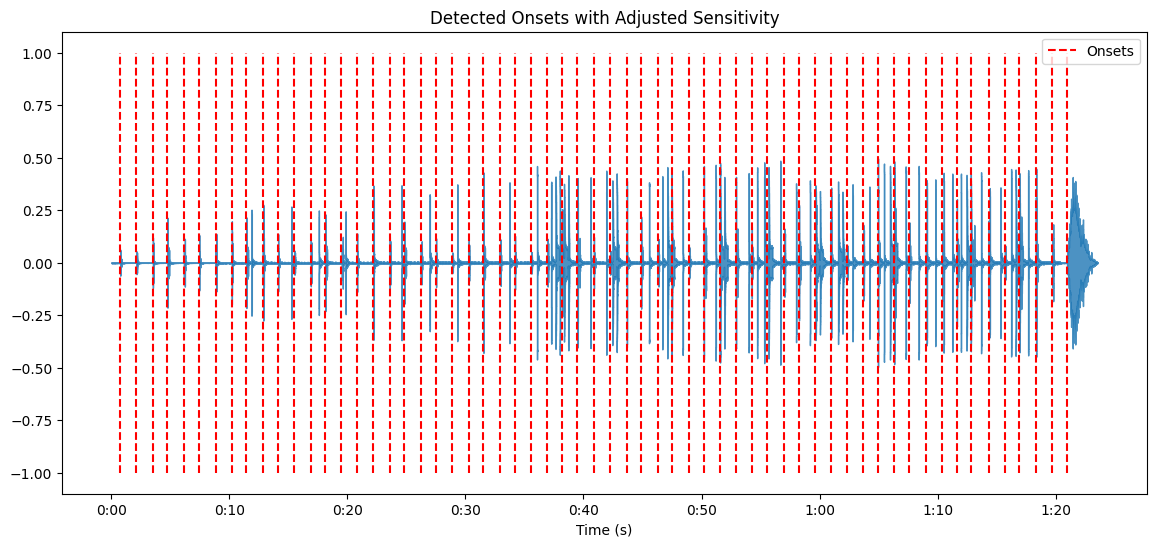

In [6]:
# Plot the waveform and onset times
plt.figure(figsize=(14, 6))
librosa.display.waveshow(y, sr=sr, alpha=0.8)
plt.vlines(seq1, ymin=-1, ymax=1, color='r', linestyle='--', label='Onsets')
plt.title('Detected Onsets with Adjusted Sensitivity')
plt.xlabel('Time (s)')
plt.legend()
plt.show()


In [ ]:
import pandas as pd

# Create a DataFrame
df_seq = pd.DataFrame({"onset_times": seq1})


# Define the file path
file_path = 'parm_onsets_librosa_drops_filtered.csv'

# Save the DataFrame to a CSV file
df_seq.to_csv(file_path, index=False)

# Print the dynamic message
print(f"Sequence has been saved to '{file_path}'")

Sequence has been saved to 'parm_onsets_librosa_drops_filtered.csv'
